# Convert craftax obs to image

- https://github.com/MichaelTMatthews/Craftax/blob/main/obs_description.md

- [ ] obs 2 env state (opposite of render_craftax_symbolic)
- [ ] env state 2 px

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from craftax.craftax.renderer import render_craftax_pixels, render_craftax_symbolic
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Loading textures from cache


In [3]:
from copy import deepcopy
from twm.config import CONFIGS
config = deepcopy(CONFIGS['test'])
config.update({
    'game': 'Breakout', 
    # 'seed': args.seed, 'model_device': args.device, 'buffer_device': buffer_device,
    # 'cpu_p': args.cpu_p, 'save': args.save
})
config

{'buffer_capacity': 10000,
 'buffer_temperature': 20.0,
 'buffer_prefill': 1000,
 'budget': 1000000000,
 'pretrain_budget': 50000,
 'pretrain_obs_p': 0.6,
 'pretrain_dyn_p': 0.3,
 'eval_every': 500,
 'eval_episodes': 10,
 'final_eval_episodes': 100,
 'env_frame_size': 8268,
 'env_frame_skip': 1,
 'env_frame_stack': 4,
 'env_grayscale': True,
 'env_noop_max': 30,
 'env_time_limit': 2700,
 'env_episodic_lives': True,
 'env_reward_transform': 'tanh',
 'env_discount_factor': 0.99,
 'env_discount_lambda': 0.95,
 'wm_batch_size': 100,
 'wm_sequence_length': 16,
 'wm_train_steps': 1,
 'wm_memory_length': 16,
 'wm_discount_threshold': 0.1,
 'z_categoricals': 32,
 'z_categories': 32,
 'obs_channels': 48,
 'obs_act': 'silu',
 'obs_norm': 'none',
 'obs_dropout': 0,
 'obs_lr': 0.0001,
 'obs_wd': 1e-06,
 'obs_eps': 1e-05,
 'obs_grad_clip': 100,
 'obs_entropy_coef': 5,
 'obs_entropy_threshold': 0.1,
 'obs_consistency_coef': 0.01,
 'obs_decoder_coef': 1,
 'dyn_embed_dim': 256,
 'dyn_num_heads': 4,
 '

In [4]:
from twm.envs.craftax import create_craftax_env
noop_max = 0 if eval else config['env_noop_max']
env = create_craftax_env(
    config['game'], noop_max, config['env_frame_skip'], config['env_frame_stack'],
    config['env_frame_size'], config['env_episodic_lives'], config['env_grayscale'], config['env_time_limit'])
obs, _ = env.reset()
obs.shape 

(4, 8268)

In [5]:
state = env.env_state.__dict__
state.keys()

dict_keys(['map', 'item_map', 'mob_map', 'light_map', 'down_ladders', 'up_ladders', 'chests_opened', 'monsters_killed', 'player_position', 'player_level', 'player_direction', 'player_health', 'player_food', 'player_drink', 'player_energy', 'player_mana', 'is_sleeping', 'is_resting', 'player_recover', 'player_hunger', 'player_thirst', 'player_fatigue', 'player_recover_mana', 'player_xp', 'player_dexterity', 'player_strength', 'player_intelligence', 'inventory', 'melee_mobs', 'passive_mobs', 'ranged_mobs', 'mob_projectiles', 'mob_projectile_directions', 'player_projectiles', 'player_projectile_directions', 'growing_plants_positions', 'growing_plants_age', 'growing_plants_mask', 'potion_mapping', 'learned_spells', 'sword_enchantment', 'bow_enchantment', 'armour_enchantments', 'boss_progress', 'boss_timesteps_to_spawn_this_round', 'light_level', 'achievements', 'state_rng', 'timestep', 'fractal_noise_angles'])

0 [0 0 0 0] 0
1 [0 0 0 0] 0
2 [0 0 0 0] 0
3 [0 0 0 0] 0


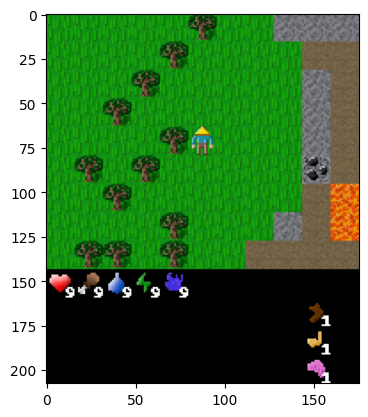

In [7]:
# Image.fromarray(im._value)

## sym2state

0 [0 0 0 0] 0
1 [0 0 0 0] 0
2 [0 0 0 0] 0
3 [0 0 0 0] 0


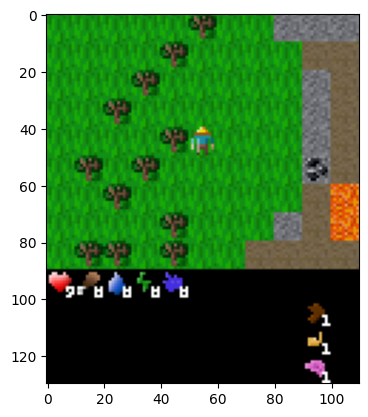

In [40]:
import numpy as np
import numpy as np
from craftax.craftax.craftax_state import EnvState, Inventory, Mobs
from craftax.craftax.constants import MAX_OBS_DIM, OBS_DIM, BlockType, ItemType, MONSTERS_KILLED_TO_CLEAR_LEVEL
from craftax.craftax.util.game_logic_utils import is_boss_vulnerable

def inverse_render_craftax_symbolic(flattened, env_state):
    # Extract sizes
    all_map_size = np.prod(OBS_DIM) * (len(BlockType) + len(ItemType) + 5 * 8 + 1)
    inventory_size = 16
    potions_size = 6
    armour_size = 4
    armour_enchantments_size = 4
    intrinsics_size = 9
    direction_size = 4
    special_values_size = 8

    # Split the flattened array into respective components
    start = 0
    end = all_map_size
    all_map_flattened = flattened[start:end].reshape((*OBS_DIM, len(BlockType) + len(ItemType) + 5 * 8 + 1))

    start = end
    end += inventory_size
    inventory = flattened[start:end]

    start = end
    end += potions_size
    potions = flattened[start:end].astype(np.int32)

    start = end
    end += intrinsics_size
    intrinsics = flattened[start:end]

    start = end
    end += direction_size
    direction = flattened[start:end]

    start = end
    end += armour_size
    armour = flattened[start:end].astype(np.int32)

    start = end
    end += armour_enchantments_size
    armour_enchantments = flattened[start:end]

    start = end
    end += special_values_size
    special_values = flattened[start:end]

    # Reconstruct map, item map, mob map, and light map
    map = all_map_flattened[:, :, :len(BlockType)].argmax(-1)
    item_map = all_map_flattened[:, :, len(BlockType):len(BlockType) + len(ItemType)].argmax(-1)
    mob_map = all_map_flattened[:, :, len(BlockType) + len(ItemType):-1].argmax(-1)
    light_map_view = all_map_flattened[:, :, -1] > 0.05

    # pad the maps from (9,11) to to 9, 48, 48
    map = np.pad(map[None, :], ((0, 8), (20, 19), (19, 18)), mode='constant', constant_values=0)
    item_map = np.pad(item_map[None, :], ((0, 8), (20, 19), (19, 18)), mode='constant', constant_values=0)
    mob_map = np.pad(mob_map[None, :], ((0, 8), (20, 19), (19, 18)), mode='constant', constant_values=0)
    light_map_view = np.pad(light_map_view[None, :], ((0, 8), (20, 19), (19, 18)), mode='constant', constant_values=0)

    # Extract mobs information from mob_map
    mobs = {}  # This would need a more detailed extraction based on mob_map encoding

    # Extract other state components
    state = EnvState(
        map=map,
        item_map=item_map,
        mob_map=mob_map,
        light_map=light_map_view,
        down_ladders=env_state.down_ladders,  # Assuming placeholders for missing data
        up_ladders=env_state.up_ladders,
        chests_opened=env_state.chests_opened,
        monsters_killed=env_state.monsters_killed,
        player_position=env_state.player_position,
        player_level=int(special_values[5] * 10.0),
        player_direction=np.argmax(direction) + 1,
        player_health=intrinsics[0] * 10.0,
        player_food=int(intrinsics[1] * 10.0),
        player_drink=int(intrinsics[2] * 10.0),
        player_energy=int(intrinsics[3] * 10.0),
        player_mana=int(intrinsics[4] * 10.0),
        is_sleeping=bool(special_values[1]),
        is_resting=bool(special_values[2]),
        player_recover=env_state.player_recover,
        player_hunger=env_state.player_hunger,
        player_thirst=env_state.player_thirst,
        player_fatigue=env_state.player_fatigue,
        player_recover_mana=env_state.player_recover_mana,
        player_xp=int(intrinsics[5] * 10.0),
        player_dexterity=int(intrinsics[6] * 10.0),
        player_strength=int(intrinsics[7] * 10.0),
        player_intelligence=int(intrinsics[8] * 10.0),
        inventory=Inventory(
            wood=int((inventory[0] * 10.0) ** 2),
            stone=int((inventory[1] * 10.0) ** 2),
            coal=int((inventory[2] * 10.0) ** 2),
            iron=int((inventory[3] * 10.0) ** 2),
            diamond=int((inventory[4] * 10.0) ** 2),
            sapling=int((inventory[5] * 10.0) ** 2),
            pickaxe=int(inventory[11] * 4.0),
            sword=int(inventory[12] * 4.0),
            bow=int(inventory[15]),
            arrows=int((inventory[9] * 10.0) ** 2),
            armour=armour * 2,
            torches=int((inventory[8] * 10.0) ** 2),
            ruby=int((inventory[6] * 10.0) ** 2),
            sapphire=int((inventory[7] * 10.0) ** 2),
            potions=(potions * 10) ** 2,
            books=int(inventory[10] * 2.0)
        ),
        melee_mobs=env_state.melee_mobs,
        passive_mobs=env_state.passive_mobs,
        ranged_mobs=env_state.ranged_mobs,
        mob_projectiles=env_state.mob_projectiles,
        mob_projectile_directions=env_state.mob_projectile_directions,
        player_projectiles=env_state.player_projectiles,
        player_projectile_directions=env_state.player_projectile_directions,
        growing_plants_positions=env_state.growing_plants_positions,
        growing_plants_age=env_state.growing_plants_age,
        growing_plants_mask=env_state.growing_plants_mask,
        potion_mapping=env_state.potion_mapping,
        learned_spells=special_values[3:5].astype(bool),
        sword_enchantment=int(inventory[13]),
        bow_enchantment=int(inventory[14]),
        armour_enchantments=armour_enchantments.astype(int),
        boss_progress=env_state.boss_progress,
        boss_timesteps_to_spawn_this_round=env_state.boss_timesteps_to_spawn_this_round,
        light_level=float(special_values[0]),
        achievements=env_state.achievements,
        state_rng=env_state.state_rng,
        timestep=env_state.timestep,
        fractal_noise_angles=env_state.fractal_noise_angles
    )

    return state

env_state = inverse_render_craftax_symbolic(obs[0].numpy(), env_state=env.env_state, )
env_state
im = render_craftax_pixels(env_state, block_pixel_size=10).astype(np.uint8)
plt.imshow(im)

0 [0 0 0 0] 0
1 [0 0 0 0] 0
2 [0 0 0 0] 0
3 [0 0 0 0] 0


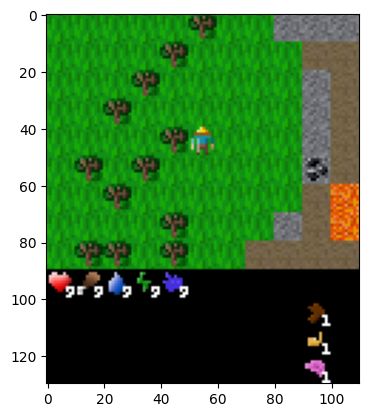

In [39]:
im = render_craftax_pixels(env.env_state, block_pixel_size=10).astype(np.uint8)
plt.imshow(im)